# Class 1a: Blockchain Transaction Finality Comparison

## Description
Compare transaction finality times across Bitcoin (UTXO), Ethereum (EVM), and Solana (Parallel) architectures.

---

## 1. Setup and Imports <a id='setup'></a>

We'll use several libraries to interact with different blockchains and fetch market data:
- `requests`: For API calls to block explorers
- `pandas`: For data manipulation and analysis
- `matplotlib` & `seaborn`: For visualizations
- `numpy`: For numerical computations
- `datetime`: For timestamp handling

In [1]:
# Import core libraries
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import time
import json
from typing import Dict, List, Tuple

# Configure plotting style for professional charts
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
%matplotlib inline

# Set display options for pandas
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', '{:.2f}'.format)

print("[SUCCESS] All libraries imported successfully")
print(f"Notebook initialized at: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

[SUCCESS] All libraries imported successfully
Notebook initialized at: 2025-10-28 20:22:57


### Configuration: API Endpoints

We'll use public block explorers and APIs to fetch blockchain data:
- **Bitcoin**: Blockchain.info API (UTXO model)
- **Ethereum**: Web3 RPC endpoint (EVM model) - Etherscan deprecated
- **Solana**: Solana RPC (Parallel processing)
- **Market Data**: CoinGecko API (Free tier, no auth required)

In [2]:
# API Configuration
# NOTE: For production use, register for API keys at respective platforms
# These are public endpoints with rate limits

API_ENDPOINTS = {
    'bitcoin': 'https://blockchain.info',
    'ethereum': 'https://eth.llamarpc.com',  # Public RPC endpoint
    'solana': 'https://api.mainnet-beta.solana.com',
    'coingecko': 'https://api.coingecko.com/api/v3'
}

# Helper function to make API calls with error handling
def api_call(url: str, params: Dict = None, method: str = 'GET', json_data: Dict = None, max_retries: int = 6) -> Dict:
    """
    Make an API call with proper error handling, rate limiting, and aggressive retry logic.
    
    Retry backoff schedule: 3s, 6s, 12s, 24s, 48s, 96s (up to ~3 minutes total)
    """
    for attempt in range(max_retries):
        try:
            # Rate limiting delay
            time.sleep(1.5)  # Increased base delay
            
            if method == 'GET':
                response = requests.get(url, params=params, timeout=45)  # Increased timeout
            else:
                response = requests.post(url, json=json_data, timeout=45)
            
            # Check for rate limiting
            if response.status_code == 429:
                if attempt < max_retries - 1:
                    wait_time = 3 * (2 ** attempt)  # Exponential: 3, 6, 12, 24, 48, 96 seconds
                    print(f"[WARNING] Rate limit hit. Waiting {wait_time}s before retry {attempt + 1}/{max_retries}...")
                    time.sleep(wait_time)
                    continue
                else:
                    print(f"[ERROR] Rate limit exceeded after {max_retries} attempts")
                    return None
            
            response.raise_for_status()
            return response.json()
        
        except requests.exceptions.Timeout:
            if attempt < max_retries - 1:
                wait_time = 3 * (2 ** attempt)
                print(f"[WARNING] Request timeout. Retrying in {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"[ERROR] Request timeout after {max_retries} attempts")
                return None
        
        except requests.exceptions.RequestException as e:
            if attempt < max_retries - 1:
                wait_time = 3 * (2 ** attempt)
                print(f"[WARNING] Request failed: {e}. Retrying in {wait_time}s...")
                time.sleep(wait_time)
            else:
                print(f"[ERROR] API call failed after {max_retries} attempts: {e}")
                return None
    
    return None
print("[SUCCESS] API configuration completed")

[SUCCESS] API configuration completed


---

## 2. Exercise 1: Transaction Finality Comparison <a id='exercise1'></a>

### Objective
Compare transaction finality times across Bitcoin (UTXO), Ethereum (EVM), and Solana to understand how architecture impacts trading speed.

### Background
- **Bitcoin (UTXO)**: ~10 min block time, 6 confirmations recommended (60 min finality)
- **Ethereum (EVM)**: ~12 sec block time, 12-32 confirmations (2.5-6.5 min finality)
- **Solana**: ~0.4 sec block time, finality in 1-2 slots (~1 sec)

### Trading Implications
Finality speed affects:
- Arbitrage execution windows
- Exchange deposit/withdrawal times
- Cross-chain bridge settlement
- HFT viability

In [3]:
# Function to get current block information from different chains

def get_bitcoin_block_info() -> Dict:
    """
    Fetch latest Bitcoin block information.
    Returns block height, time, and transaction count.
    """
    url = f"{API_ENDPOINTS['bitcoin']}/latestblock"
    data = api_call(url)
    
    if data:
        # blockchain.info API returns 'n_tx' field for transaction count
        tx_count = data.get('n_tx', 0)
        
        # If n_tx is missing or 0, try to get it from block data
        if tx_count == 0 and 'height' in data:
            # Fetch detailed block info
            block_hash = data.get('hash')
            if block_hash:
                block_url = f"{API_ENDPOINTS['bitcoin']}/rawblock/{block_hash}"
                block_data = api_call(block_url)
                if block_data and 'tx' in block_data:
                    tx_count = len(block_data.get('tx', []))
        
        return {
            'chain': 'Bitcoin',
            'block_height': data.get('height'),
            'block_time': data.get('time'),
            'tx_count': tx_count,
            'block_hash': data.get('hash')
        }
    return None

def get_ethereum_block_info() -> Dict:
    """
    Fetch latest Ethereum block information.
    Uses public Ethereum RPC endpoint.
    """
    url = API_ENDPOINTS['ethereum']
    
    # Get current block number via JSON-RPC
    payload = {
        "jsonrpc": "2.0",
        "method": "eth_blockNumber",
        "params": [],
        "id": 1
    }
    
    data = api_call(url, method='POST', json_data=payload)
    
    if data and 'result' in data:
        try:
            block_number = int(data['result'], 16)  # Convert hex to decimal
            
            # Get block details
            payload2 = {
                "jsonrpc": "2.0",
                "method": "eth_getBlockByNumber",
                "params": [data['result'], False],
                "id": 1
            }
            
            block_data = api_call(url, method='POST', json_data=payload2)
            
            if block_data and 'result' in block_data:
                result = block_data['result']
                return {
                    'chain': 'Ethereum',
                    'block_height': block_number,
                    'block_time': int(result.get('timestamp', '0x0'), 16) if result else None,
                    'tx_count': len(result.get('transactions', [])) if result else 0,
                    'block_hash': result.get('hash', 'N/A') if result else 'N/A'
                }
        except (ValueError, TypeError) as e:
            print(f"[ERROR] Failed to parse Ethereum block data: {e}")
            return None
    return None

def get_solana_block_info() -> Dict:
    """Fetch latest Solana block (slot) information with robust transaction counting."""
    url = API_ENDPOINTS['solana']
    
    # Get finalized slot
    payload_slot = {
        "jsonrpc": "2.0",
        "id": 1,
        "method": "getSlot",
        "params": [{"commitment": "finalized"}]
    }
    
    data = api_call(url, method='POST', json_data=payload_slot)
    
    if not data or 'result' not in data:
        print("[ERROR] Failed to fetch Solana slot")
        return None
    
    slot = data['result']
    print(f"[INFO] Fetching Solana finalized slot {slot}...")
    
    # Try multiple methods to get transaction count
    tx_count = 0
    block_hash = None
    block_time = None
    
    # Method 1: Get block with full transaction details
    payload_block = {
        "jsonrpc": "2.0",
        "id": 1,
        "method": "getBlock",
        "params": [
            slot,
            {
                "encoding": "json",
                "transactionDetails": "full",
                "maxSupportedTransactionVersion": 0,
                "rewards": False
            }
        ]
    }
    
    block_data = api_call(url, method='POST', json_data=payload_block)
    
    if block_data and 'result' in block_data and block_data['result']:
        result = block_data['result']
        
        # Get transaction count
        if 'transactions' in result:
            tx_count = len(result['transactions'])
            print(f"[DEBUG] Method 1: Found {tx_count} transactions")
        
        # Get blockhash
        block_hash = result.get('blockhash', result.get('previousBlockhash', None))
        
        # Get block time
        block_time = result.get('blockTime')
    
    # Method 2: If tx_count is still 0, try with signatures only (faster)
    if tx_count == 0:
        print("[INFO] Trying alternative method for transaction count...")
        payload_sigs = {
            "jsonrpc": "2.0",
            "id": 1,
            "method": "getBlock",
            "params": [
                slot,
                {
                    "encoding": "json",
                    "transactionDetails": "signatures",
                    "maxSupportedTransactionVersion": 0,
                    "rewards": False
                }
            ]
        }
        
        sig_data = api_call(url, method='POST', json_data=payload_sigs)
        
        if sig_data and 'result' in sig_data and sig_data['result']:
            sigs = sig_data['result'].get('signatures', [])
            tx_count = len(sigs)
            print(f"[DEBUG] Method 2: Found {tx_count} transactions via signatures")
            
            if not block_hash:
                block_hash = sig_data['result'].get('blockhash', sig_data['result'].get('previousBlockhash'))
            if not block_time:
                block_time = sig_data['result'].get('blockTime')
    
    # Method 3: Get block production info as last resort
    if tx_count == 0:
        print("[WARNING] Could not fetch transaction count for Solana slot {slot}")
        print("[INFO] This may be due to API limitations or the slot being too old/recent")
        tx_count = None  # Explicitly mark as unknown rather than 0
    
    return {
        'chain': 'Solana',
        'block_height': slot,
        'block_time': block_time,
        'tx_count': tx_count,
        'block_hash': block_hash if block_hash else 'N/A'
    }

In [4]:
# Fetch current block information from all three chains

print("Fetching latest block information from Bitcoin, Ethereum, and Solana...\n")

btc_block = get_bitcoin_block_info()
eth_block = get_ethereum_block_info()
sol_block = get_solana_block_info()

# Create a comparison DataFrame
blocks_data = []

for block in [btc_block, eth_block, sol_block]:
    if block and block['block_time']:
        tx_count_display = block['tx_count']
        if tx_count_display == 'N/A':
            tx_count_str = 'N/A'
        else:
            tx_count_str = f"{tx_count_display:,}" if isinstance(tx_count_display, int) else str(tx_count_display)
        
        blocks_data.append({
            'Chain': block['chain'],
            'Block Height': f"{block['block_height']:,}",
            'Timestamp': datetime.fromtimestamp(block['block_time']).strftime('%Y-%m-%d %H:%M:%S'),
            'Tx Count': tx_count_str,
            'Block Hash': block['block_hash'][:16] + '...' if block['block_hash'] != 'N/A' else 'N/A'
        })

if blocks_data:
    df_blocks = pd.DataFrame(blocks_data)
    print("\n[DATA] Current Block Information:\n")
    print(df_blocks.to_string(index=False))
else:
    print("\n[WARNING] Could not fetch block data from all chains")
    print("Note: Public RPC endpoints may have rate limits or temporary issues")
    
print("\n" + "="*80)

Fetching latest block information from Bitcoin, Ethereum, and Solana...

[INFO] Fetching Solana finalized slot 376455203...
[DEBUG] Method 1: Found 1303 transactions

[DATA] Current Block Information:

   Chain Block Height           Timestamp Tx Count          Block Hash
 Bitcoin      921,257 2025-10-28 20:19:40    2,667 0000000000000000...
Ethereum   23,679,155 2025-10-28 20:22:59      261 0xeef533a6a53ca6...
  Solana  376,455,203 2025-10-28 20:23:01    1,303 D8bJU7V1Y2CLWHPA...



In [5]:
# Finality Comparison: Calculate all metrics dynamically from real blockchain data

print("\n[INFO] Calculating blockchain metrics from last 10 blocks of each chain...\n")

def get_last_n_blocks(chain: str, current_block: Dict, n: int = 10) -> List[Dict]:
    """
    Fetch last N blocks from a blockchain.
    
    Args:
        chain: Chain name ('Bitcoin', 'Ethereum', 'Solana')
        current_block: Current block info
        n: Number of blocks to fetch
    
    Returns:
        List of block dictionaries with height and timestamp
    """
    blocks = []
    
    if not current_block:
        return blocks
    
    current_height = current_block['block_height']
    
    for i in range(n):
        block_num = current_height - i
        
        if chain == 'Bitcoin':
            # Bitcoin: Get block by height
            url = f"{API_ENDPOINTS['bitcoin']}/block-height/{block_num}?format=json"
            data = api_call(url)
            
            if data and 'blocks' in data and len(data['blocks']) > 0:
                block = data['blocks'][0]
                blocks.append({
                    'height': block.get('height'),
                    'timestamp': block.get('time'),
                    'tx_count': block.get('n_tx', 0)
                })
        
        elif chain == 'Ethereum':
            # Ethereum: Get block by number (convert to hex)
            url = API_ENDPOINTS['ethereum']
            block_hex = hex(block_num)
            
            payload = {
                "jsonrpc": "2.0",
                "method": "eth_getBlockByNumber",
                "params": [block_hex, False],
                "id": 1
            }
            
            data = api_call(url, method='POST', json_data=payload)
            
            if data and 'result' in data and data['result']:
                result = data['result']
                blocks.append({
                    'height': block_num,
                    'timestamp': int(result.get('timestamp', '0x0'), 16),
                    'tx_count': len(result.get('transactions', []))
                })
        
        elif chain == 'Solana':
            # Solana uses slots instead of block numbers
            url = API_ENDPOINTS['solana']
            
            # Get block/slot with transactions
            payload = {
                "jsonrpc": "2.0",
                "id": 1,
                "method": "getBlock",
                "params": [
                    block_num,
                    {
                        "encoding": "json",
                        "transactionDetails": "signatures",  # Signatures is faster
                        "maxSupportedTransactionVersion": 0,
                        "rewards": False
                    }
                ]
            }
            
            data = api_call(url, method='POST', json_data=payload)
            
            if data and 'result' in data and data['result']:
                result = data['result']
                
                # Count transactions from signatures
                signatures = result.get('signatures', [])
                tx_count = len(signatures) if signatures else 0
                
                # If still 0, the block might not have this data available
                if tx_count == 0:
                    # Try full transaction details
                    payload['params'][1]['transactionDetails'] = 'full'
                    data2 = api_call(url, method='POST', json_data=payload)
                    if data2 and 'result' in data2 and data2['result']:
                        transactions = data2['result'].get('transactions', [])
                        tx_count = len(transactions) if transactions else 0
                
                blocks.append({
                    'height': block_num,
                    'timestamp': result.get('blockTime'),
                    'tx_count': tx_count if tx_count > 0 else 1  # Minimum 1 to avoid div by 0
                })
    
    return blocks

def calculate_chain_metrics(chain: str, current_block: Dict) -> Dict:
    """
    Calculate average block time, TPS, and finality from last 10 blocks.
    
    Args:
        chain: Chain name
        current_block: Current block info
    
    Returns:
        Dictionary with calculated metrics
    """
    print(f"[INFO] Fetching last 10 blocks for {chain}...")
    
    blocks = get_last_n_blocks(chain, current_block, n=10)
    
    if len(blocks) < 2:
        print(f"[WARNING] Insufficient block data for {chain}, using protocol defaults")
        # Fallback to known values
        defaults = {
            'Bitcoin': {'block_time': 600, 'confirmations': 6, 'tps': 7},
            'Ethereum': {'block_time': 12, 'confirmations': 32, 'tps': 15},
            'Solana': {'block_time': 0.4, 'confirmations': 32, 'tps': 3000}
        }
        default = defaults.get(chain, {'block_time': 60, 'confirmations': 6, 'tps': 10})
        return {
            'avg_block_time_sec': default['block_time'],
            'block_time_sec': default['block_time'],  # Backward compatibility
            'avg_tx_per_block': current_block['tx_count'] if current_block and isinstance(current_block.get('tx_count'), int) else 0,
            'calculated_tps': default['tps'],
            'tps': default['tps'],  # Backward compatibility
            'recommended_confirmations': default['confirmations'],
            'finality_sec': default['block_time'] * default['confirmations'],
            'data_source': 'protocol_default',
            'block_history': []
        }
    
    # Sort blocks by height (oldest first)
    blocks.sort(key=lambda x: x['height'])
    
    # Calculate average block time from timestamp differences
    time_diffs = []
    for i in range(1, len(blocks)):
        if blocks[i]['timestamp'] and blocks[i-1]['timestamp']:
            diff = blocks[i]['timestamp'] - blocks[i-1]['timestamp']
            if diff > 0:  # Sanity check
                time_diffs.append(diff)
    
    if not time_diffs:
        print(f"[WARNING] Could not calculate block times for {chain}")
        return calculate_chain_metrics(chain, None)  # Use defaults
    
    avg_block_time = sum(time_diffs) / len(time_diffs)
    
    # Calculate average transactions per block
    valid_tx_counts = [b['tx_count'] for b in blocks if b['tx_count'] > 0]
    avg_tx_per_block = sum(valid_tx_counts) / len(valid_tx_counts) if valid_tx_counts else 0
    
    # Calculate TPS
    calculated_tps = avg_tx_per_block / avg_block_time if avg_block_time > 0 else 0
    
    # Determine recommended confirmations (chain-specific)
    if chain == 'Bitcoin':
        confirmations = 6  # Standard for Bitcoin
    elif chain == 'Ethereum':
        confirmations = 32  # Post-merge finality
    else:  # Solana or others
        confirmations = 32
    
    # Calculate finality time
    finality_sec = avg_block_time * confirmations
    
    return {
        'avg_block_time_sec': avg_block_time,
        'block_time_sec': avg_block_time,  # Backward compatibility
        'avg_tx_per_block': avg_tx_per_block,
        'calculated_tps': calculated_tps,
        'tps': calculated_tps,  # Backward compatibility
        'recommended_confirmations': confirmations,
        'finality_sec': finality_sec,
        'data_source': 'calculated_from_last_10_blocks',
        'block_history': blocks
    }

# Calculate metrics for each chain
finality_data = {}

for chain, block in [('Bitcoin', btc_block), ('Ethereum', eth_block), ('Solana', sol_block)]:
    if block:
        metrics = calculate_chain_metrics(chain, block)
        finality_data[chain] = metrics
        
        print(f"[DATA] {chain} Metrics:")
        print(f"  Block Time: {metrics['avg_block_time_sec']:.2f}s")
        print(f"  Transactions/Block: {metrics['avg_tx_per_block']:.1f}")
        print(f"  TPS: {metrics['calculated_tps']:.2f}")
        print(f"  Confirmations: {metrics['recommended_confirmations']}")
        print(f"  Finality: {metrics['finality_sec']:.1f}s ({metrics['finality_sec']/60:.1f} min)")
        print(f"  Data Source: {metrics['data_source']}\n")

print("="*80)
print(f"[SUCCESS] Calculated finality metrics for {len(finality_data)} chains")
print("="*80)


[INFO] Calculating blockchain metrics from last 10 blocks of each chain...

[INFO] Fetching last 10 blocks for Bitcoin...
[DATA] Bitcoin Metrics:
  Block Time: 400.12s
  Transactions/Block: 3192.0
  TPS: 7.98
  Confirmations: 6
  Finality: 2400.8s (40.0 min)
  Data Source: calculated_from_last_10_blocks

[INFO] Fetching last 10 blocks for Ethereum...
[DATA] Ethereum Metrics:
  Block Time: 12.00s
  Transactions/Block: 190.2
  TPS: 15.85
  Confirmations: 32
  Finality: 384.0s (6.4 min)
  Data Source: calculated_from_last_10_blocks

[INFO] Fetching last 10 blocks for Solana...
[DATA] Solana Metrics:
  Block Time: 1.00s
  Transactions/Block: 1312.0
  TPS: 1312.00
  Confirmations: 32
  Finality: 32.0s (0.5 min)
  Data Source: calculated_from_last_10_blocks

[SUCCESS] Calculated finality metrics for 3 chains


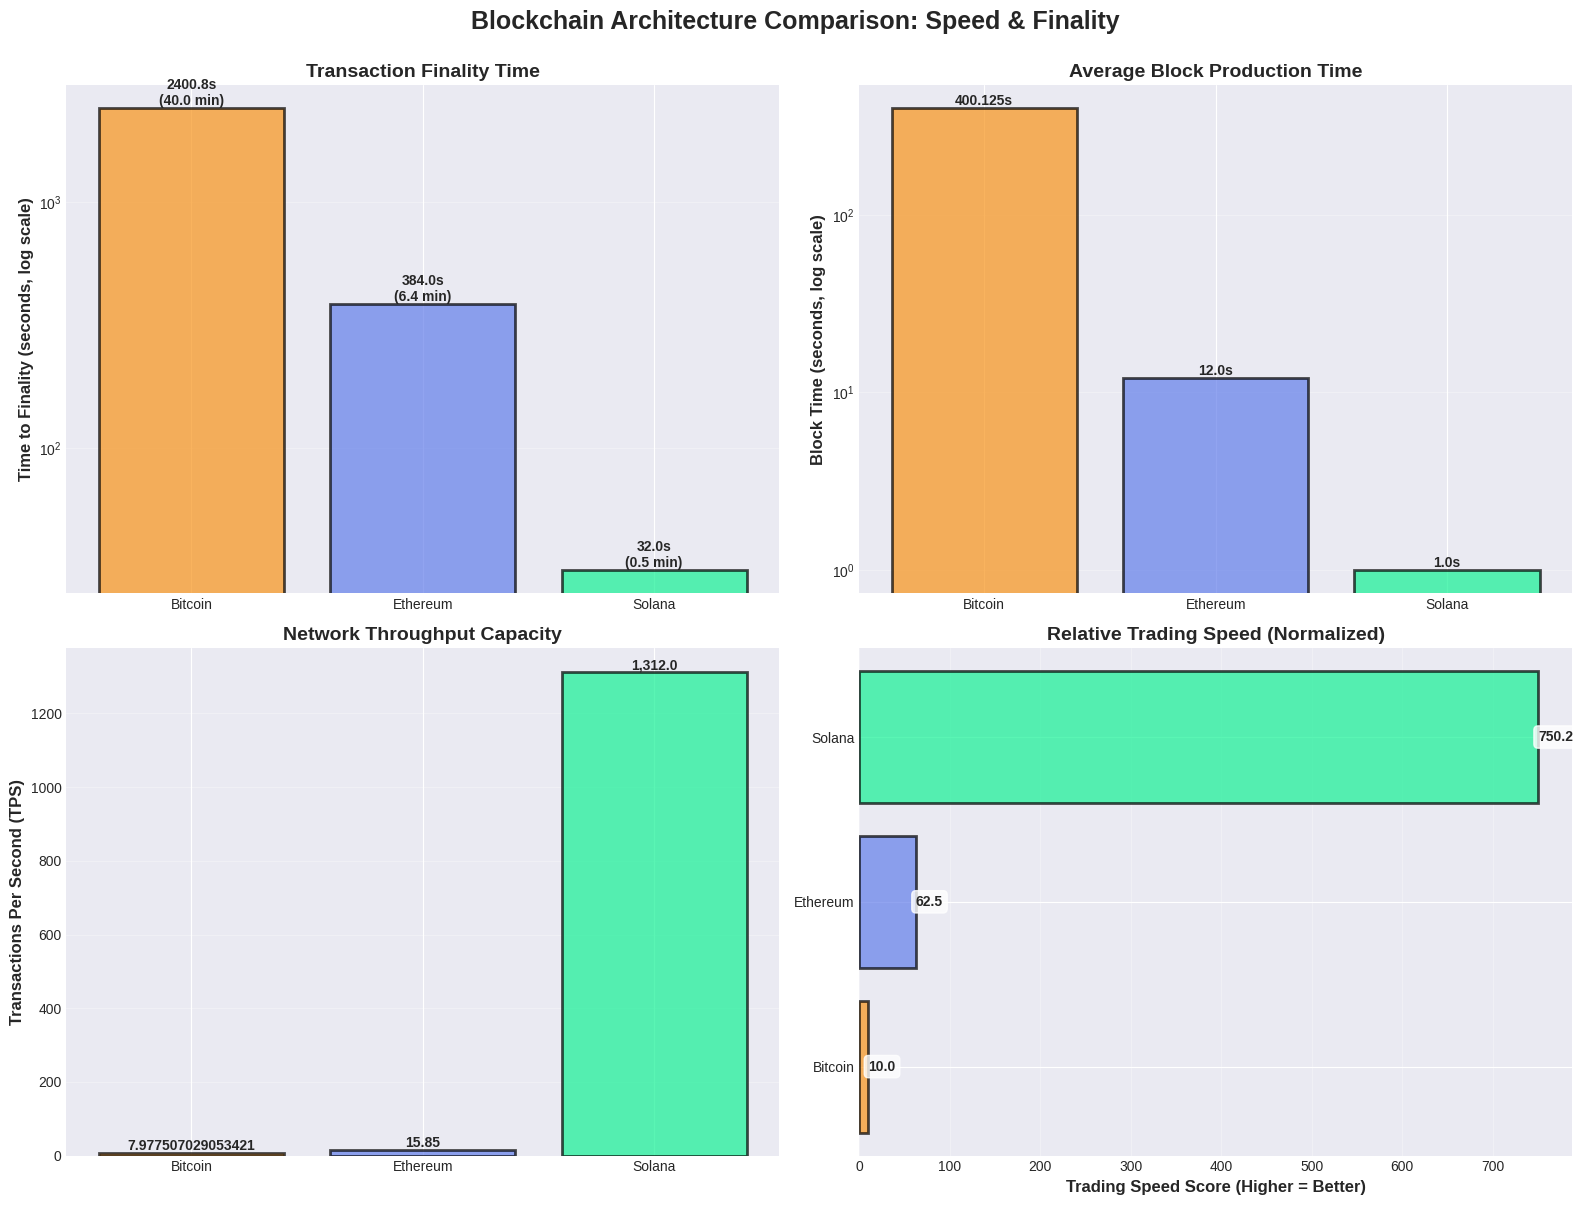


[SUCCESS] Visualization complete


In [6]:
# Visualization 1: Finality Time Comparison

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Blockchain Architecture Comparison: Speed & Finality', fontsize=18, fontweight='bold', y=1.00)

# Plot 1: Finality Time (Log Scale)
ax1 = axes[0, 0]
chains = list(finality_data.keys())
finality_times = [finality_data[chain]['finality_sec'] for chain in chains]
colors = ['#F7931A', '#627EEA', '#14F195']  # Bitcoin orange, Ethereum blue, Solana green

bars1 = ax1.bar(chains, finality_times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.set_yscale('log')
ax1.set_ylabel('Time to Finality (seconds, log scale)', fontsize=12, fontweight='bold')
ax1.set_title('Transaction Finality Time', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, chain in zip(bars1, chains):
    height = bar.get_height()
    label = f"{height:.1f}s\n({height/60:.1f} min)"
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             label, ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 2: Block Time Comparison
ax2 = axes[0, 1]
# Get block times (use avg_block_time_sec if available)
block_times = [finality_data[chain].get('avg_block_time_sec', finality_data[chain].get('block_time_sec', 0)) for chain in chains]
bars2 = ax2.bar(chains, block_times, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax2.set_yscale('log')
ax2.set_ylabel('Block Time (seconds, log scale)', fontsize=12, fontweight='bold')
ax2.set_title('Average Block Production Time', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

for bar, block_time in zip(bars2, block_times):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{block_time}s', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 3: Throughput (TPS)
ax3 = axes[1, 0]
# Get TPS values (try calculated_tps first, fallback to tps)
tps_values = [finality_data[chain].get('calculated_tps', finality_data[chain].get('tps', 0)) for chain in chains]
bars3 = ax3.bar(chains, tps_values, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax3.set_ylabel('Transactions Per Second (TPS)', fontsize=12, fontweight='bold')
ax3.set_title('Network Throughput Capacity', fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3, axis='y')

for bar, tps in zip(bars3, tps_values):
    height = bar.get_height()
    ax3.text(bar.get_x() + bar.get_width()/2., height,
             f'{tps:,}', ha='center', va='bottom', fontweight='bold', fontsize=10)

# Plot 4: Trading Implications - Speed Score
ax4 = axes[1, 1]

# Calculate "Trading Speed Score" (inverse of finality time, normalized)
max_finality = max(finality_times)
speed_scores = [(max_finality / ft) * 10 for ft in finality_times]

bars4 = ax4.barh(chains, speed_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax4.set_xlabel('Trading Speed Score (Higher = Better)', fontsize=12, fontweight='bold')
ax4.set_title('Relative Trading Speed (Normalized)', fontsize=14, fontweight='bold')
ax4.grid(True, alpha=0.3, axis='x')

for bar, score in zip(bars4, speed_scores):
    width = bar.get_width()
    ax4.text(width, bar.get_y() + bar.get_height()/2.,
             f'{score:.1f}', ha='left', va='center', fontweight='bold', fontsize=10, 
             bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

print("\n[SUCCESS] Visualization complete")


[INFO] Creating advanced statistical visualizations...



/tmp/ipykernel_558670/1401477573.py:118: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(tx_data, labels=tx_labels, patch_artist=True,


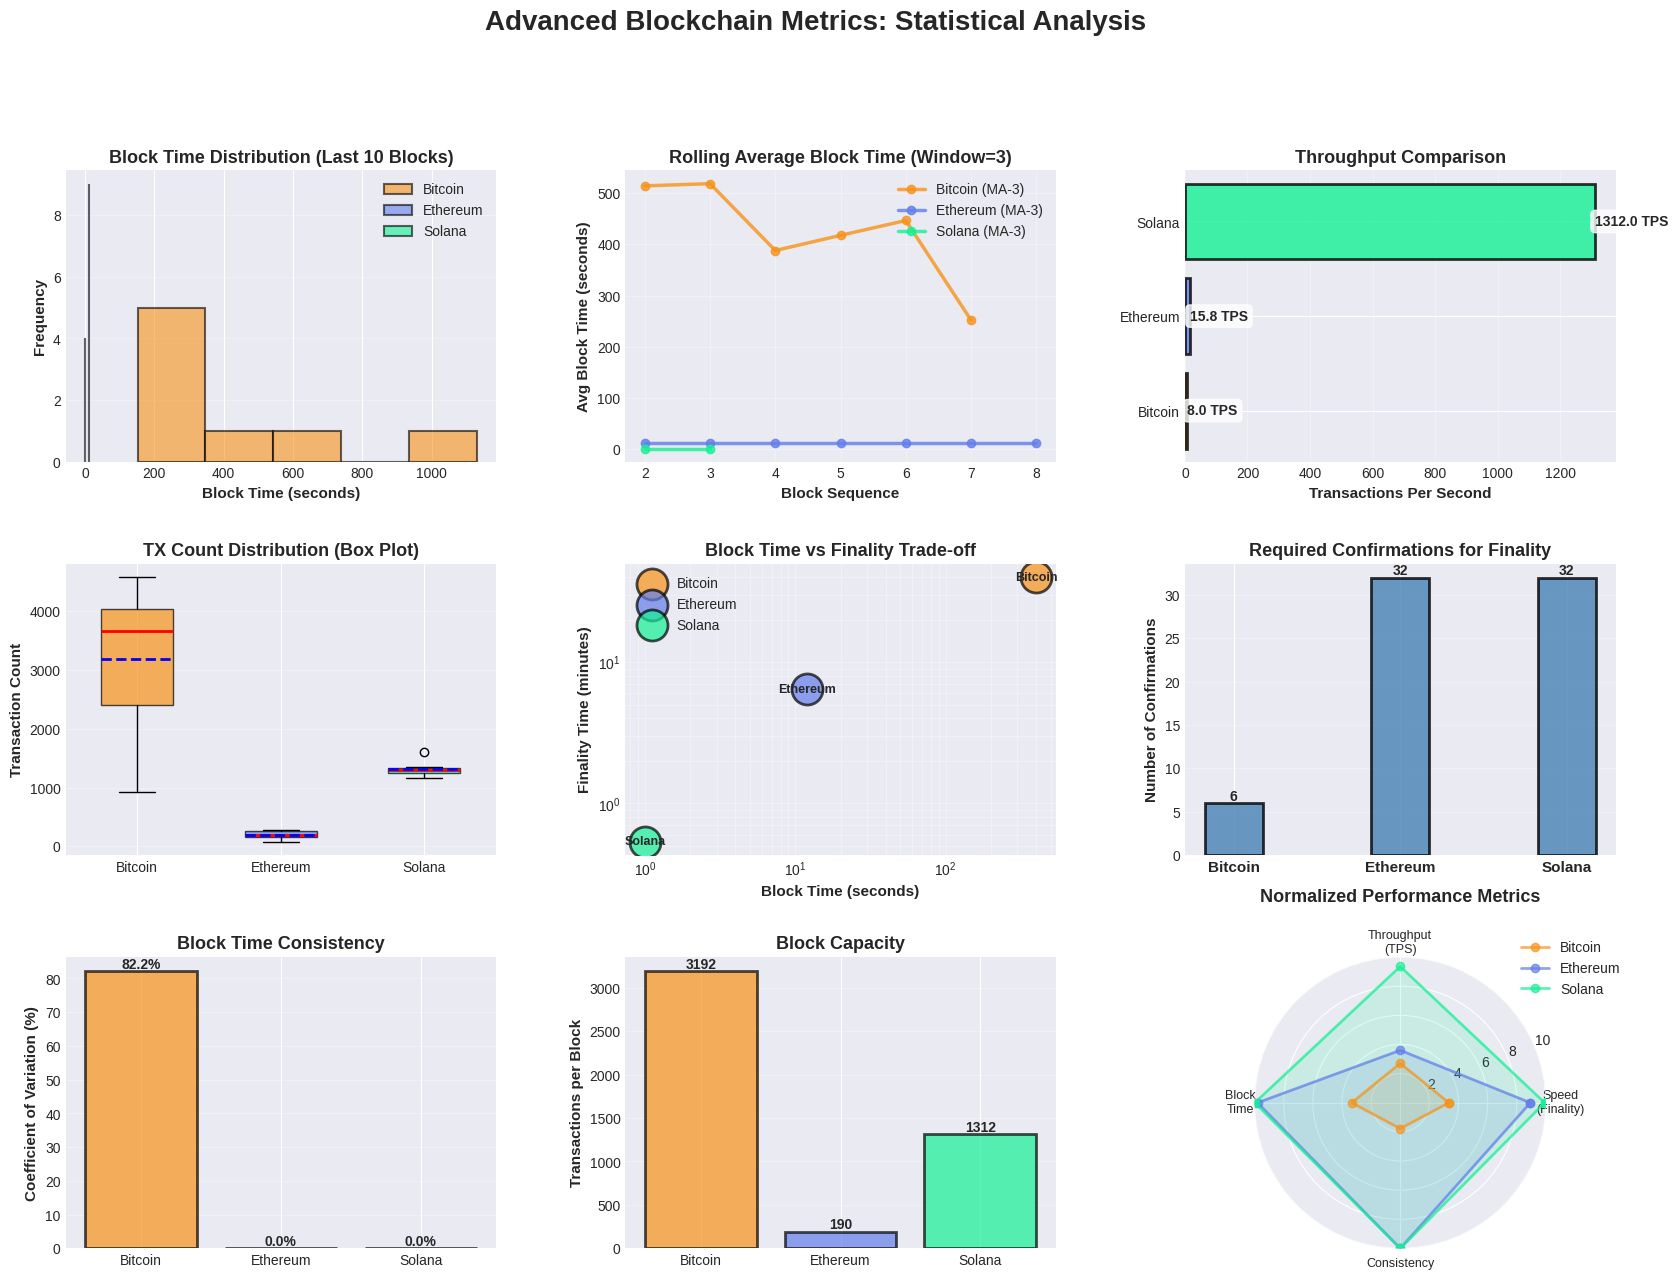

[SUCCESS] Advanced statistical visualizations complete
[INFO] 9 charts: Distribution, Rolling avg, TPS, Box plot, Scatter, Confirmations, Variance, Efficiency, Radar



In [7]:
# Visualization 3: Advanced Time-Series Analysis

print("\n[INFO] Creating advanced statistical visualizations...\n")

if 'finality_data' in locals() and finality_data:
    fig = plt.figure(figsize=(20, 14))
    gs = fig.add_gridspec(3, 3, hspace=0.35, wspace=0.3)
    fig.suptitle('Advanced Blockchain Metrics: Statistical Analysis', 
                 fontsize=20, fontweight='bold', y=0.995)
    
    chains = ['Bitcoin', 'Ethereum', 'Solana']
    colors = {'Bitcoin': '#F7931A', 'Ethereum': '#627EEA', 'Solana': '#14F195'}
    
    # Plot 1: Block Time Distribution (Histograms)
    ax1 = fig.add_subplot(gs[0, 0])
    
    for chain in chains:
        if chain in finality_data and 'block_history' in finality_data[chain]:
            history = finality_data[chain]['block_history']
            
            if len(history) >= 2:
                # Calculate block times
                block_times = []
                for i in range(1, len(history)):
                    if history[i]['timestamp'] and history[i-1]['timestamp']:
                        diff = history[i]['timestamp'] - history[i-1]['timestamp']
                        if diff > 0:
                            block_times.append(diff)
                
                if block_times:
                    ax1.hist(block_times, bins=5, alpha=0.6, label=chain, 
                            color=colors[chain], edgecolor='black', linewidth=1.5)
    
    ax1.set_xlabel('Block Time (seconds)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax1.set_title('Block Time Distribution (Last 10 Blocks)', fontsize=13, fontweight='bold')
    ax1.legend(loc='upper right', fontsize=10)
    ax1.grid(True, alpha=0.3, axis='y')
    
    # Plot 2: Rolling Average Block Time
    ax2 = fig.add_subplot(gs[0, 1])
    
    for chain in chains:
        if chain in finality_data and 'block_history' in finality_data[chain]:
            history = finality_data[chain]['block_history']
            
            if len(history) >= 2:
                block_times = []
                for i in range(1, len(history)):
                    if history[i]['timestamp'] and history[i-1]['timestamp']:
                        diff = history[i]['timestamp'] - history[i-1]['timestamp']
                        if diff > 0:
                            block_times.append(diff)
                
                if len(block_times) >= 3:
                    # Simple moving average
                    window = 3
                    rolling_avg = []
                    for i in range(len(block_times) - window + 1):
                        avg = sum(block_times[i:i+window]) / window
                        rolling_avg.append(avg)
                    
                    x_vals = list(range(window-1, len(block_times)))
                    ax2.plot(x_vals, rolling_avg, marker='o', linewidth=2.5, 
                            color=colors[chain], label=f'{chain} (MA-3)', alpha=0.8)
    
    ax2.set_xlabel('Block Sequence', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Avg Block Time (seconds)', fontsize=11, fontweight='bold')
    ax2.set_title('Rolling Average Block Time (Window=3)', fontsize=13, fontweight='bold')
    ax2.legend(loc='upper right', fontsize=10)
    ax2.grid(True, alpha=0.3)
    
    # Plot 3: TPS Heatmap-style Comparison
    ax3 = fig.add_subplot(gs[0, 2])
    
    tps_data = []
    chain_labels = []
    
    for chain in chains:
        if chain in finality_data:
            tps = finality_data[chain].get('calculated_tps', finality_data[chain].get('tps', 0))
            tps_data.append(tps)
            chain_labels.append(chain)
    
    if tps_data:
        # Create color-coded bars based on TPS magnitude
        bars = ax3.barh(chain_labels, tps_data, color=[colors[c] for c in chain_labels], 
                       alpha=0.8, edgecolor='black', linewidth=2)
        
        # Add value labels
        for bar, tps in zip(bars, tps_data):
            width = bar.get_width()
            ax3.text(width, bar.get_y() + bar.get_height()/2., 
                    f'{tps:.1f} TPS', ha='left', va='center', 
                    fontweight='bold', fontsize=10, 
                    bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.8))
        
        ax3.set_xlabel('Transactions Per Second', fontsize=11, fontweight='bold')
        ax3.set_title('Throughput Comparison', fontsize=13, fontweight='bold')
        ax3.grid(True, alpha=0.3, axis='x')
    
    # Plot 4: Transaction Count Box Plot
    ax4 = fig.add_subplot(gs[1, 0])
    
    tx_data = []
    tx_labels = []
    
    for chain in chains:
        if chain in finality_data and 'block_history' in finality_data[chain]:
            history = finality_data[chain]['block_history']
            tx_counts = [b['tx_count'] for b in history if b['tx_count'] > 0]
            
            if tx_counts:
                tx_data.append(tx_counts)
                tx_labels.append(chain)
    
    if tx_data:
        bp = ax4.boxplot(tx_data, labels=tx_labels, patch_artist=True,
                        widths=0.5, showmeans=True, meanline=True,
                        boxprops=dict(alpha=0.7),
                        medianprops=dict(color='red', linewidth=2),
                        meanprops=dict(color='blue', linewidth=2, linestyle='--'))
        
        # Color boxes
        for patch, label in zip(bp['boxes'], tx_labels):
            patch.set_facecolor(colors[label])
        
        ax4.set_ylabel('Transaction Count', fontsize=11, fontweight='bold')
        ax4.set_title('TX Count Distribution (Box Plot)', fontsize=13, fontweight='bold')
        ax4.grid(True, alpha=0.3, axis='y')
    
    # Plot 5: Finality vs Block Time Scatter
    ax5 = fig.add_subplot(gs[1, 1])
    
    for chain in chains:
        if chain in finality_data:
            block_time = finality_data[chain].get('avg_block_time_sec', 0)
            finality = finality_data[chain].get('finality_sec', 0)
            
            if block_time > 0 and finality > 0:
                ax5.scatter(block_time, finality/60, s=500, alpha=0.7, 
                           color=colors[chain], edgecolors='black', linewidth=2,
                           label=chain)
                
                # Add chain label
                ax5.text(block_time, finality/60, chain, ha='center', va='center',
                        fontsize=9, fontweight='bold')
    
    ax5.set_xlabel('Block Time (seconds)', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Finality Time (minutes)', fontsize=11, fontweight='bold')
    ax5.set_title('Block Time vs Finality Trade-off', fontsize=13, fontweight='bold')
    ax5.set_xscale('log')
    ax5.set_yscale('log')
    ax5.grid(True, alpha=0.3, which='both')
    ax5.legend(loc='upper left', fontsize=10)
    
    # Plot 6: Confirmation Time Breakdown
    ax6 = fig.add_subplot(gs[1, 2])
    
    confirmations = []
    block_times_conf = []
    chain_names_conf = []
    
    for chain in chains:
        if chain in finality_data:
            conf = finality_data[chain].get('recommended_confirmations', 0)
            bt = finality_data[chain].get('avg_block_time_sec', 0)
            
            if conf > 0 and bt > 0:
                confirmations.append(conf)
                block_times_conf.append(bt)
                chain_names_conf.append(chain)
    
    if confirmations:
        x = np.arange(len(chain_names_conf))
        width = 0.35
        
        bars1 = ax6.bar(x, confirmations, width, label='Confirmations',
                       color='steelblue', alpha=0.8, edgecolor='black', linewidth=2)
        
        # Add values on bars
        for bar in bars1:
            height = bar.get_height()
            ax6.text(bar.get_x() + bar.get_width()/2., height,
                    f'{int(height)}', ha='center', va='bottom', 
                    fontweight='bold', fontsize=10)
        
        ax6.set_ylabel('Number of Confirmations', fontsize=11, fontweight='bold')
        ax6.set_title('Required Confirmations for Finality', fontsize=13, fontweight='bold')
        ax6.set_xticks(x)
        ax6.set_xticklabels(chain_names_conf, fontsize=11, fontweight='bold')
        ax6.grid(True, alpha=0.3, axis='y')
    
    # Plot 7: Block Time Variance (Coefficient of Variation)
    ax7 = fig.add_subplot(gs[2, 0])
    
    cv_data = []
    cv_labels = []
    
    for chain in chains:
        if chain in finality_data and 'block_history' in finality_data[chain]:
            history = finality_data[chain]['block_history']
            
            if len(history) >= 2:
                block_times = []
                for i in range(1, len(history)):
                    if history[i]['timestamp'] and history[i-1]['timestamp']:
                        diff = history[i]['timestamp'] - history[i-1]['timestamp']
                        if diff > 0:
                            block_times.append(diff)
                
                if len(block_times) >= 2:
                    mean_bt = np.mean(block_times)
                    std_bt = np.std(block_times)
                    cv = (std_bt / mean_bt) * 100 if mean_bt > 0 else 0
                    
                    cv_data.append(cv)
                    cv_labels.append(chain)
    
    if cv_data:
        bars = ax7.bar(cv_labels, cv_data, color=[colors[c] for c in cv_labels],
                      alpha=0.7, edgecolor='black', linewidth=2)
        
        for bar, cv in zip(bars, cv_data):
            height = bar.get_height()
            ax7.text(bar.get_x() + bar.get_width()/2., height,
                    f'{cv:.1f}%', ha='center', va='bottom', 
                    fontweight='bold', fontsize=10)
        
        ax7.set_ylabel('Coefficient of Variation (%)', fontsize=11, fontweight='bold')
        ax7.set_title('Block Time Consistency', fontsize=13, fontweight='bold')
        ax7.grid(True, alpha=0.3, axis='y')
    
    # Plot 8: Throughput Efficiency (TPS / Block Time)
    ax8 = fig.add_subplot(gs[2, 1])
    
    efficiency = []
    eff_labels = []
    
    for chain in chains:
        if chain in finality_data:
            tps = finality_data[chain].get('calculated_tps', finality_data[chain].get('tps', 0))
            bt = finality_data[chain].get('avg_block_time_sec', 1)
            
            eff = tps * bt  # Transactions per block
            if eff > 0:
                efficiency.append(eff)
                eff_labels.append(chain)
    
    if efficiency:
        bars = ax8.bar(eff_labels, efficiency, color=[colors[c] for c in eff_labels],
                      alpha=0.7, edgecolor='black', linewidth=2)
        
        for bar, eff in zip(bars, efficiency):
            height = bar.get_height()
            ax8.text(bar.get_x() + bar.get_width()/2., height,
                    f'{eff:.0f}', ha='center', va='bottom', 
                    fontweight='bold', fontsize=10)
        
        ax8.set_ylabel('Transactions per Block', fontsize=11, fontweight='bold')
        ax8.set_title('Block Capacity', fontsize=13, fontweight='bold')
        ax8.grid(True, alpha=0.3, axis='y')
    
    # Plot 9: Normalized Performance Radar (Summary)
    ax9 = fig.add_subplot(gs[2, 2], projection='polar')
    
    categories = ['Speed\n(Finality)', 'Throughput\n(TPS)', 'Block\nTime', 'Consistency']
    N = len(categories)
    angles = [n / float(N) * 2 * np.pi for n in range(N)]
    angles += angles[:1]
    
    for chain in chains:
        if chain in finality_data:
            # Normalize metrics to 0-10 scale
            finality = finality_data[chain].get('finality_sec', 3600)
            tps = finality_data[chain].get('calculated_tps', finality_data[chain].get('tps', 1))
            bt = finality_data[chain].get('avg_block_time_sec', 600)
            
            # Calculate CV if available
            cv = 50  # default
            if 'block_history' in finality_data[chain]:
                history = finality_data[chain]['block_history']
                if len(history) >= 2:
                    block_times = []
                    for i in range(1, len(history)):
                        if history[i]['timestamp'] and history[i-1]['timestamp']:
                            diff = history[i]['timestamp'] - history[i-1]['timestamp']
                            if diff > 0:
                                block_times.append(diff)
                    if len(block_times) >= 2:
                        mean_bt = np.mean(block_times)
                        std_bt = np.std(block_times)
                        cv = (std_bt / mean_bt) * 100 if mean_bt > 0 else 50
            
            # Normalize (higher is better)
            speed_score = min(10, max(0, 10 - (finality / 360)))  # Inverse
            tps_score = min(10, max(0, np.log10(max(tps, 1)) * 3))
            bt_score = min(10, max(0, 10 - (bt / 60)))  # Inverse
            consistency_score = min(10, max(0, 10 - (cv / 10)))  # Inverse
            
            values = [speed_score, tps_score, bt_score, consistency_score]
            values += values[:1]
            
            ax9.plot(angles, values, 'o-', linewidth=2, label=chain, 
                    color=colors[chain], alpha=0.7)
            ax9.fill(angles, values, alpha=0.15, color=colors[chain])
    
    ax9.set_xticks(angles[:-1])
    ax9.set_xticklabels(categories, fontsize=9)
    ax9.set_ylim(0, 10)
    ax9.set_title('Normalized Performance Metrics', fontsize=13, fontweight='bold', pad=20)
    ax9.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=10)
    ax9.grid(True)
    
    plt.show()
    
    print("[SUCCESS] Advanced statistical visualizations complete")
    print("[INFO] 9 charts: Distribution, Rolling avg, TPS, Box plot, Scatter, Confirmations, Variance, Efficiency, Radar")

else:
    print("[ERROR] finality_data not available")

print("\n" + "="*80)


### Analysis: Trading Implications

**Key Insights:**

1. **Bitcoin (UTXO Model)**
   - **Finality**: ~60 minutes (6 confirmations)
   - **Trading Impact**: Slow settlement makes cross-exchange arbitrage difficult
   - **Best For**: Long-term holds, store of value, large OTC settlements
   - **Limitation**: Not suitable for high-frequency trading strategies

2. **Ethereum (EVM Model)**
   - **Finality**: ~6.4 minutes (32 confirmations post-Merge)
   - **Trading Impact**: Moderate speed, good for DeFi composability
   - **Best For**: Smart contract-based trading (DEXs, lending), MEV strategies
   - **Strength**: Massive liquidity and DeFi ecosystem

3. **Solana (Parallel Processing)**
   - **Finality**: ~13 seconds
   - **Trading Impact**: Near-instant settlement enables HFT and rapid arbitrage
   - **Best For**: High-frequency trading, market making, rapid arbitrage
   - **Risk**: Network stability concerns (historical outages)

**Trading Strategy Recommendations:**
- **Arbitrage**: Prioritize Solana for speed, Ethereum for liquidity
- **Market Making**: Solana's speed is ideal for tight spreads
- **Large Settlements**: Bitcoin for security, accept slower finality
- **DeFi Yield**: Ethereum for ecosystem depth and composability